# Proudění dýzou s proměnným průřezem

In [1]:
%matplotlib inline

from numpy import *
import matplotlib.pyplot as plt

In [2]:
def A(x):
    return 1 + (x-0.5)**2

In [3]:
kappa = 1.4

In [4]:
RHO_  = 0
RHOU_ = 1
RHOE_ = 2

In [5]:
def pressure(W):
    p = (kappa-1) * (W[RHOE_] - 0.5 * W[RHOU_]**2/W[RHO_])
    return p


def Mach(W):
    p = pressure(W)
    rho = W[RHO_]
    a = sqrt(kappa * p / rho)
    M = W[RHOU_]/W[RHO_] / a
    return M


def eigen(W):
    rho  = W[RHO_]
    rhou = W[RHOU_]
    p    = pressure(W)
    u    = rhou / rho
    a    = sqrt(kappa*p/rho)
    return u - a, u, u + a
    

def sigma(W):
    eig = eigen(W)
    return max(abs(eig[0]),abs(eig[1]), abs(eig[2]))


def flux(W):
    rho  = W[RHO_]
    rhou = W[RHOU_]
    rhoE = W[RHOE_]
    p    = pressure(W)
    u    = rhou / rho

    return array([ rho*u, rhou * u + p,  (rhoE + p) * u])

In [6]:
def HLL(Wl, Wr):
    Fl = flux(Wl)
    Fr = flux(Wr)
    
    eigl = eigen(Wl)
    eigr = eigen(Wr)
    sl = min(eigl[0], eigr[0])
    sr = max(eigl[-1], eigr[-1])
    
    if 0.0 <= sl:
        return Fl
    elif 0.0 < sr:
        return (sr*Fl - sl*Fr + sl*sr*(Wr-Wl)) / (sr - sl)
    else:
        return Fr

In [7]:
def Inlet(W):
    pTot   = 1.e5
    rhoTot = 1.2
    
    p  = pressure(W)
    p  = min(p, pTot)
    M2 = 2. / (kappa-1) * ((p/pTot)**((1.-kappa)/kappa) - 1)
    rho= rhoTot * (1 + (kappa-1)/2 * M2)**(1/(1-kappa))
    u  = sqrt(M2 * kappa * p / rho)
    rhoE  = p / (kappa-1) + 0.5*rho*u**2
    
    return array([ rho, rho * u,  rhoE])

In [8]:
def Outlet(W):
    p2   = 0.8 * 1.e5
    rhoE  = p2 / (kappa-1) + 0.5*W[RHOU_]**2/W[RHO_]
    
    return array([ W[RHO_], W[RHOU_], rhoE])

In [9]:
def InitialCondition(n):
    W = zeros((3,n))
    W[RHO_,:]  = 1.0
    W[RHOU_,:] = 0.0
    W[RHOE_,:] = 1.e5 / (kappa-1)
    return W

In [10]:
def Reziduum1(W, NumFlux):
    n = size(W,1)
    dx = 1.0 / n
    
    F = zeros((3,n+1))
    
    F[:,0]  = A(0) * NumFlux( Inlet(W[:,0]), W[:,0])
    F[:,-1] = A(1) * NumFlux( W[:,-1], Outlet(W[:,-1]))
    
    for i in range(1,n):
        F[:,i] = A(i*dx) * NumFlux( W[:,i-1], W[:,i] )
        
    rez = zeros((3,n))
    for i in range(n):
        p = pressure(W[:,i])
        Q = array([ 0.0, p * (A((i+1)*dx)-A(i*dx)), 0.0 ])
        rez[:,i] = ( F[:,i+1] - F[:,i] - Q ) / (dx * A((i+0.5)*dx))
    
    return rez

In [11]:
def solve1(W0, Rez, NumFlux):
    iters = 20000
    history = zeros(iters)
    n = size(W0,1)
    dx = 1.0 / n
    W = copy(W0)
    
    for it in range(iters):
        dt = 0.8 * min([dx/sigma(W[:,i]) for i in range(n)])
        r = Rez(W, NumFlux)
        W -= dt*r
    
        history[it] = sqrt(sum(r[RHO_,:]**2))
        
    return W, history

In [12]:
n = 50
dx = 1.0 / n
x=linspace(dx/2,1-dx/2,n)

In [13]:
W0 = InitialCondition(n)

In [14]:
W1, history1 = solve1(W0, Reziduum1, HLL)

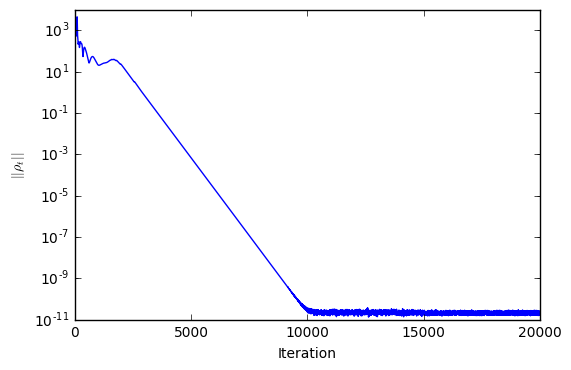

In [15]:
plt.semilogy(history1, label="HLL, 1st order");
plt.xlabel("Iteration"); plt.ylabel(r"$||\rho_t||$");

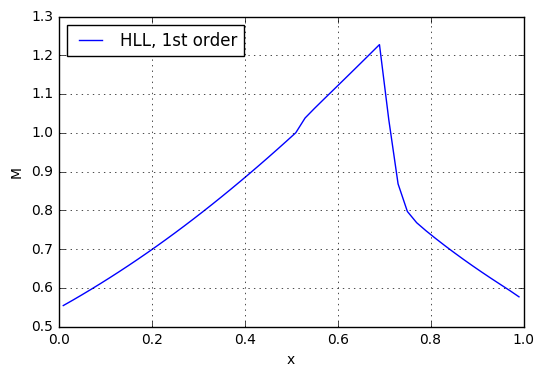

In [16]:
plt.plot(x, Mach(W1), label="HLL, 1st order");
plt.xlabel("x"); plt.ylabel("M");
plt.legend(loc="upper left");
plt.grid(True)

In [17]:
def Rusanov(Wl, Wr):
    Fl = flux(Wl)
    Fr = flux(Wr)
    s = max( sigma(Wl), sigma(Wr) )
    
    return (Fl + Fr) / 2.0 - s / 2.0 * (Wr - Wl)

In [18]:
W1ru, history1ru = solve1(W0, Reziduum1, Rusanov)

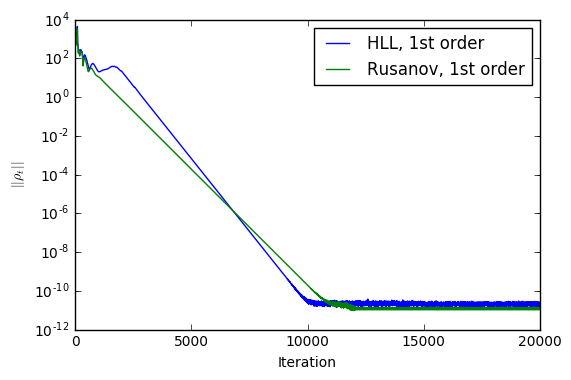

In [19]:
plt.semilogy(history1, label="HLL, 1st order");
plt.semilogy(history1ru, label="Rusanov, 1st order");
plt.legend(loc="upper right")
plt.xlabel("Iteration"); plt.ylabel(r"$||\rho_t||$");

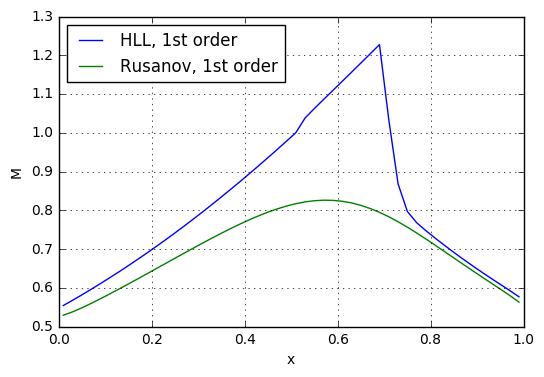

In [20]:
plt.plot(x, Mach(W1), label="HLL, 1st order");
plt.plot(x, Mach(W1ru), label="Rusanov, 1st order");
plt.xlabel("x"); plt.ylabel("M");
plt.legend(loc="upper left");
plt.grid(True)

In [21]:
nf  = 200
dxf = 1.0 / n
xf  = linspace(dxf/2,1-dxf/2,nf)
W0f = InitialCondition(nf)

In [22]:
W1ruf, history1ruf = solve1(W0f, Reziduum1, Rusanov)

In [23]:
W1f, history1f = solve1(W0f, Reziduum1, HLL)

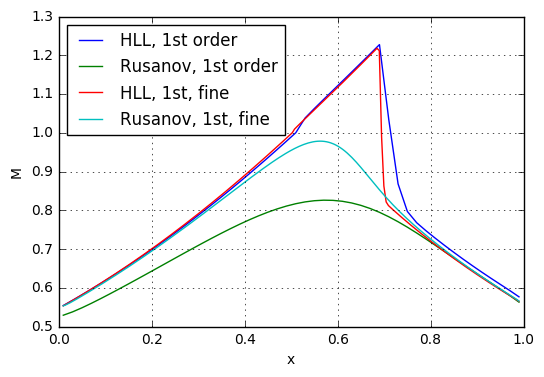

In [24]:
plt.plot(x, Mach(W1), label="HLL, 1st order");
plt.plot(x, Mach(W1ru), label="Rusanov, 1st order");
plt.plot(xf, Mach(W1f), label="HLL, 1st, fine");
plt.plot(xf, Mach(W1ruf), label="Rusanov, 1st, fine");
plt.xlabel("x"); plt.ylabel("M");
plt.legend(loc="upper left");
plt.grid(True)

## Schéma druhého řádu přesnosti

In [25]:
def Reziduum2(W, NumFlux):
    n = size(W,1)
    dx = 1.0 / n
    
    F = zeros((3,n+1))
    
    dW = copy(W)
    dW[:,0]  = W[:,1] - W[:,0]
    dW[:,-1] = W[:,-1] - W[:,-2]
    for i in range(1,n-1):
        for k in range(size(W,0)):
            
            if (W[k,i]-W[k,i-1])*(W[k,i+1]-W[k,i]) <= 0:
                dW[k,i] = 0.0
            elif abs(W[k,i]-W[k,i-1]) < abs(W[k,i+1]-W[k,i]):
                dW[k,i] = W[k,i]-W[k,i-1]
            else:
                dW[k,i] = W[k,i+1]-W[k,i]

    F[:,0]  = A(0) * NumFlux( Inlet(W[:,0]), W[:,0])
    F[:,-1] = A(1) * NumFlux( W[:,-1], Outlet(W[:,-1]))
    
    for i in range(1,n):
        F[:,i] = A(i*dx) * NumFlux( W[:,i-1] + dW[:,i-1]/2, W[:,i] - dW[:,i]/2 )
        
    rez = zeros((3,n))
    for i in range(n):
        p = pressure(W[:,i])
        Q = array([ 0.0, p * (A((i+1)*dx)-A(i*dx)), 0.0 ])
        rez[:,i] = ( F[:,i+1] - F[:,i] - Q ) / (dx * A((i+0.5)*dx))
    
    return rez

In [26]:
def solve2(W0, Rez, NumFlux):
    iters = 20000
    history = zeros(iters)
    n = size(W0,1)
    dx = 1.0 / n
    W  = copy(W0)
    Wp = copy(W0)
    
    for it in range(iters):
        dt = 0.8 * min([dx/sigma(W[:,i]) for i in range(n)])
    
        r = Rez(W, NumFlux)
        Wp = W - dt*r
    
        r = (r + Rez(Wp, NumFlux)) / 2.0
        W -= dt*r 
        history[it] = sqrt(sum(r[RHO_,:]**2))
        
    return W, history

In [27]:
W2, history2 = solve2(W0, Reziduum2, HLL)

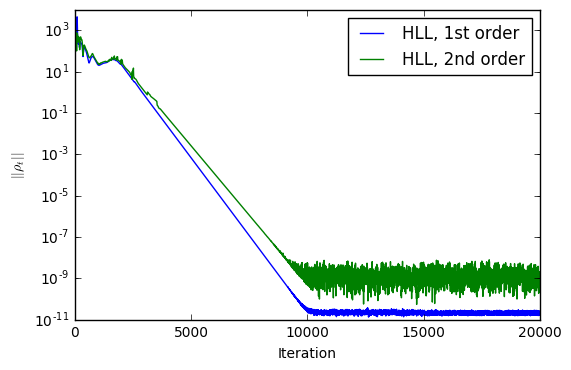

In [28]:
plt.semilogy(history1, label="HLL, 1st order");
plt.semilogy(history2, label="HLL, 2nd order");
plt.legend(loc="upper right")
plt.xlabel("Iteration"); plt.ylabel(r"$||\rho_t||$");

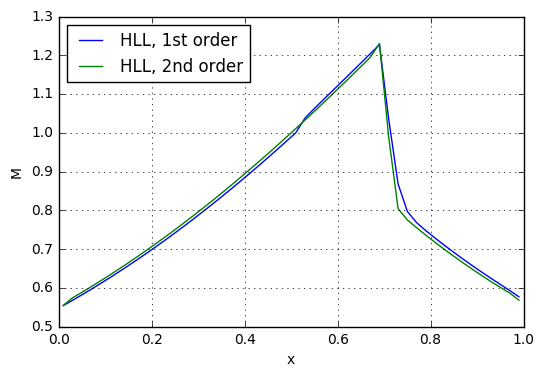

In [33]:
plt.plot(x, Mach(W1), "-", label="HLL, 1st order");
plt.plot(x, Mach(W2), "-", label="HLL, 2nd order");
plt.xlabel("x"); plt.ylabel("M");
plt.legend(loc="upper left");
plt.grid(True)

In [30]:
W2ru, history2ru = solve2(W0, Reziduum2, Rusanov)

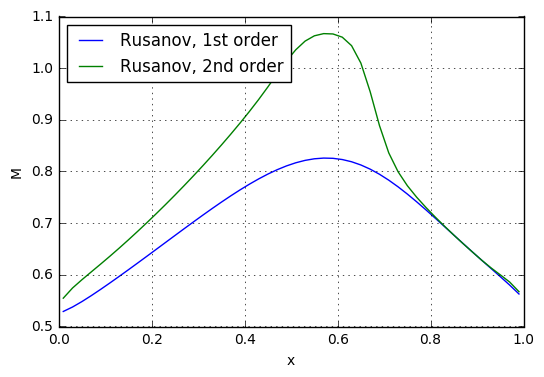

In [31]:
plt.plot(x, Mach(W1ru), label="Rusanov, 1st order");
plt.plot(x, Mach(W2ru), label="Rusanov, 2nd order");
plt.xlabel("x"); plt.ylabel("M");
plt.legend(loc="upper left");
plt.grid(True)